# NRWC AI Music Workshop

In [229]:
# Standard library imports
import json
import math
import os
import subprocess
from typing import Dict, List, Optional

# Third-party imports
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import special, stats
from scipy.special import gammaincc
from scipy.stats import chi2, chi2_contingency, wilcoxon
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.stats.multitest import fdrcorrection

# Local application imports
import helper_functions as hf  # Custom helper functions
# Run script to create json file with ordinal column config
ordinal_columns = hf.load_ordinal_columns("save_ordinal_columns.py", "ordinal_cols.json")
image_list = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6']
sound_list = ['Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12']

# Jupyter Notebook extensions
%load_ext autoreload
%autoreload 2

# File paths (Data loading section could be separated here or in a later part of the notebook)
file_path_1 = 'data/NRWC-quiz_V2.xlsx'
file_path_2 = 'data/nrwc2024-survey_V5.csv'

save_ordinal_columns.py ran successfully.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import the data 

In [230]:
df_quiz = pd.read_excel(file_path_1, sheet_name='Voters', usecols='A:O', skiprows=2) 
df_survey = pd.read_csv(file_path_2)

## Exploratory Data Analysis (EDA)

### Survey

In [231]:
# Check the structure of the data 
df_survey.head(3)

,id,What is your profession/main occupation?,What is your age?,Gender,"If in-store music is played, I would prefer the music to be human-made rather than AI-generated",I prefer in-store music rather than a silent shopping environment,I prefer highly personalized in-store music,"When facing a choice between maximum privacy and minimum personalization and minimum privacy and maximum personalization, what would you prefer?",I prefer not to share data about myself or my musical taste to companies,Submitted At
0,bzfnpztvni,Student,21,Female,I am neutral,I prefer music,Slightly agree,"moderate privacy, moderate personalization",I slightly agree,"Nov 08, 2024 09:15 am"
1,ibukcyygc6,Student,27,Female,I prefer human-made,I strongly prefer music,Slightly agree,"moderate privacy, moderate personalization",I strongly agree,"Nov 07, 2024 09:33 pm"
2,jpu5gqsbjh,Student,26,Male,I prefer human-made,I strongly prefer music,Agree,"low privacy, high personalization",I slightly agree,"Nov 07, 2024 08:11 pm"


In [232]:
# Verify data types and missing values 
df_survey.info()
# Get summary statistics 
df_survey.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 10 columns):
 #   Column                                                                                                                                            Non-Null Count  Dtype 
---  ------                                                                                                                                            --------------  ----- 
 0   id                                                                                                                                                42 non-null     object
 1   What is your profession/main occupation?                                                                                                          42 non-null     object
 2   What is your age?                                                                                                                                 42 non-null     int64 
 3   Gender                

,What is your age?
count,42.000000
mean,30.714286
std,11.970056
min,19.000000
25%,21.000000
50%,26.000000
75%,39.000000
max,62.000000


In [233]:
# Check for missing values 
df_survey.isnull().sum()

id                                                                                                                                                  0
What is your profession/main occupation?                                                                                                            0
What is your age?                                                                                                                                   0
Gender                                                                                                                                              0
If in-store music is played, I would prefer the music to be human-made rather than AI-generated                                                     0
I prefer in-store music rather than a silent shopping environment                                                                                   0
I prefer highly personalized in-store music                                                         

In [234]:
# Check for duplicates 
print(df_survey[df_survey.duplicated()])

Empty DataFrame
Columns: [id, What is your profession/main occupation?, What is your age?, Gender, If in-store music is played, I would prefer the music to be human-made rather than AI-generated, I prefer in-store music rather than a silent shopping environment, I prefer highly personalized in-store music, When facing a choice between maximum privacy and minimum personalization and minimum privacy and maximum personalization, what would you prefer?, I prefer not to share data about myself or my musical taste to companies, Submitted At]
Index: []


### Quiz 

In [235]:
df_quiz.head(3)

,Date,Session,Voter,:,:.1,:.2,:.3,:.4,:.5,:.6,:.7,:.8,:.9,:.10,:.11
0,2024-11-05,1,1,Åhlens,Naturkompaniet,XS Leker,Kappahl,Stadium,Cubus,Naturkompaniet,NaN,NaN,NaN,NaN,NaN
1,2024-11-05,2,2,Naturkompaniet,XS Leker,Stadium,Åhlens,Cubus,Kappahl,Stadium,Kappahl,XS Leker,Stadium,Naturkompaniet,Kappahl
2,2024-11-05,2,3,Kappahl,NaN,Stadium,Cubus,Åhlens,XS Leker,Stadium,Cubus,Kappahl,XS Leker,Åhlens,Stadium


In [236]:
df_quiz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     18 non-null     object
 1   Session  18 non-null     int64 
 2   Voter    18 non-null     int64 
 3   :        18 non-null     object
 4   :.1      17 non-null     object
 5   :.2      18 non-null     object
 6   :.3      18 non-null     object
 7   :.4      17 non-null     object
 8   :.5      17 non-null     object
 9   :.6      16 non-null     object
 10  :.7      16 non-null     object
 11  :.8      16 non-null     object
 12  :.9      16 non-null     object
 13  :.10     16 non-null     object
 14  :.11     16 non-null     object
dtypes: int64(2), object(13)
memory usage: 2.2+ KB


In [237]:
# Missing values 
print(df_quiz.isnull().sum())

# Descriptive statistics for question columns 
category_stats = df_quiz[df_quiz.columns[3:]].describe(include='object')
# Add missing values count row to the descriptive statistics df
missing_counts = df_quiz[df_quiz.columns[3:]].isnull().sum()
category_stats.loc['NaN'] = missing_counts
category_stats

Date       0
Session    0
Voter      0
:          0
:.1        1
:.2        0
:.3        0
:.4        1
:.5        1
:.6        2
:.7        2
:.8        2
:.9        2
:.10       2
:.11       2
dtype: int64


,:,:.1,:.2,:.3,:.4,:.5,:.6,:.7,:.8,:.9,:.10,:.11
count,18,17,18,18,17,17,16,16,16,16,16,16
unique,5,5,6,4,5,4,5,4,6,6,5,5
top,Åhlens,Kappahl,Kappahl,Cubus,Naturkompaniet,XS Leker,Cubus,XS Leker,Åhlens,Åhlens,Naturkompaniet,Stadium
freq,11,6,11,7,12,13,6,8,4,6,7,7
NaN,0,1,0,0,1,1,2,2,2,2,2,2


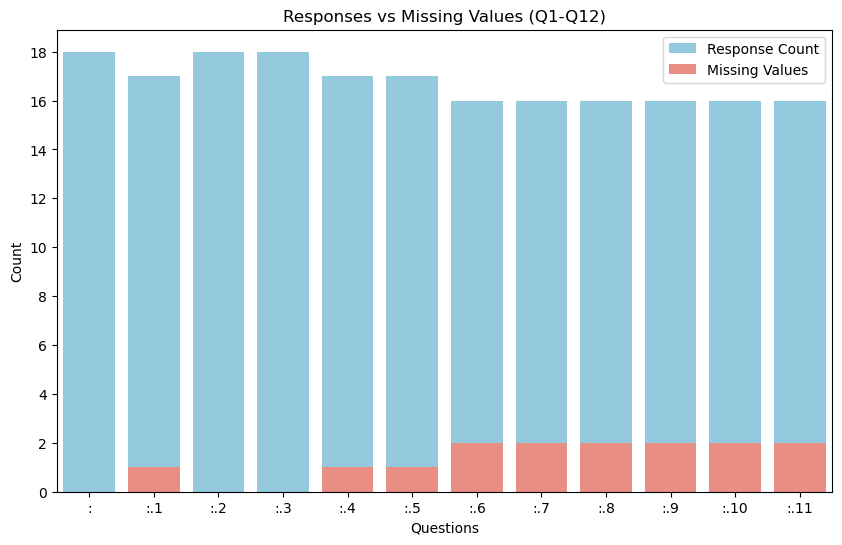

In [238]:
# Plot response counts versus missing values
plt.figure(figsize=(10, 6))
ax = plt.gca()  
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True)) # Make sure y axis has only integers, since it shows counts  
sns.barplot(x=category_stats.columns, y=category_stats.loc['count'], color='skyblue', label='Response Count')
sns.barplot(x=missing_counts.index, y=missing_counts.values, color='salmon', label='Missing Values')
plt.title('Responses vs Missing Values (Q1-Q12)')
plt.xlabel('Questions')
plt.ylabel('Count')
plt.legend()
plt.show()

In [239]:
# Check for duplicates 
print(df_survey[df_survey.duplicated()])

Empty DataFrame
Columns: [id, What is your profession/main occupation?, What is your age?, Gender, If in-store music is played, I would prefer the music to be human-made rather than AI-generated, I prefer in-store music rather than a silent shopping environment, I prefer highly personalized in-store music, When facing a choice between maximum privacy and minimum personalization and minimum privacy and maximum personalization, what would you prefer?, I prefer not to share data about myself or my musical taste to companies, Submitted At]
Index: []


## Data cleaning 

### Survey 

In [240]:
# Rename columns (names are too long) 
new_column_names = ['Id', 'Occupation', 'Age', 'Gender', 'Human_or_AI_music', 'Music_or_silence', 'Personalized_music', 'Privacy_vs_personalization', 'Sharing_data', 'Time']
df_survey.columns = new_column_names
df_survey.head(3)

,Id,Occupation,Age,Gender,Human_or_AI_music,Music_or_silence,Personalized_music,Privacy_vs_personalization,Sharing_data,Time
0,bzfnpztvni,Student,21,Female,I am neutral,I prefer music,Slightly agree,"moderate privacy, moderate personalization",I slightly agree,"Nov 08, 2024 09:15 am"
1,ibukcyygc6,Student,27,Female,I prefer human-made,I strongly prefer music,Slightly agree,"moderate privacy, moderate personalization",I strongly agree,"Nov 07, 2024 09:33 pm"
2,jpu5gqsbjh,Student,26,Male,I prefer human-made,I strongly prefer music,Agree,"low privacy, high personalization",I slightly agree,"Nov 07, 2024 08:11 pm"


In [241]:
# We see here that we have to go throuh the categories for each column and make sure naming is consistent 
# See e.g. 'I agree' vs 'Agree' for Personalized_music column, capitalization in Privacy_vs_personalization 
df_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Id                          42 non-null     object
 1   Occupation                  42 non-null     object
 2   Age                         42 non-null     int64 
 3   Gender                      42 non-null     object
 4   Human_or_AI_music           42 non-null     object
 5   Music_or_silence            42 non-null     object
 6   Personalized_music          42 non-null     object
 7   Privacy_vs_personalization  42 non-null     object
 8   Sharing_data                42 non-null     object
 9   Time                        42 non-null     object
dtypes: int64(1), object(9)
memory usage: 3.4+ KB


In [242]:
# Define the replacements as a dictionary
replacements = {
    'Agree': 'I agree',
    'Slightly agree': 'I slightly agree',
    'Strongly agree': 'I strongly agree'
}

df_survey['Personalized_music'] = df_survey['Personalized_music'].replace(replacements)
df_survey['Personalized_music'].value_counts()

Personalized_music
I am neutral           12
I slightly agree       11
I agree                 7
I disagree              5
I strongly agree        5
I strongly disagree     2
Name: count, dtype: int64

In [243]:
# Capitalize the first letter of each entry in the specified column
df_survey['Privacy_vs_personalization'] = df_survey['Privacy_vs_personalization'].str.capitalize()
df_survey['Privacy_vs_personalization'].value_counts()

Privacy_vs_personalization
Moderate privacy, moderate personalization     15
Very high privacy, very low personalization    12
Maximum privacy, minimum personalization        7
Low privacy, high personalization               4
High privacy, low personalization               4
Name: count, dtype: int64

In [244]:
# Fix data types for columns 
df_survey['Occupation'] = df_survey['Occupation'].astype('string')
df_survey['Time'] = pd.to_datetime(df_survey['Time'], format='%b %d, %Y %I:%M %p')
# Convert 'Age' to numeric, setting non-numeric values as NaN
df_survey['Age'] = pd.to_numeric(df_survey['Age'], errors='coerce')

In [245]:
# Convert to ordinal data
df_survey = df_survey.apply(lambda col: hf.convert_to_categorical(col, ordinal_columns) if col.name in ordinal_columns else col)
df_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Id                          42 non-null     object        
 1   Occupation                  42 non-null     string        
 2   Age                         42 non-null     int64         
 3   Gender                      42 non-null     object        
 4   Human_or_AI_music           42 non-null     category      
 5   Music_or_silence            42 non-null     category      
 6   Personalized_music          42 non-null     category      
 7   Privacy_vs_personalization  42 non-null     category      
 8   Sharing_data                42 non-null     category      
 9   Time                        42 non-null     datetime64[ns]
dtypes: category(5), datetime64[ns](1), int64(1), object(2), string(1)
memory usage: 3.7+ KB


In [246]:
# Check for null values 
df_survey.isna().sum()

Id                            0
Occupation                    0
Age                           0
Gender                        0
Human_or_AI_music             0
Music_or_silence              0
Personalized_music            0
Privacy_vs_personalization    0
Sharing_data                  0
Time                          0
dtype: int64

In [247]:
print('Total number of participants: ', df_survey['Id'].nunique()) 

Total number of participants:  42


In [249]:
df_survey.head(3)

,Id,Occupation,Age,Gender,Human_or_AI_music,Music_or_silence,Personalized_music,Privacy_vs_personalization,Sharing_data,Time
0,bzfnpztvni,Student,21,Female,I am neutral,I prefer music,I slightly agree,"Moderate privacy, moderate personalization",I slightly agree,2024-11-08 09:15:00
1,ibukcyygc6,Student,27,Female,I prefer human-made,I strongly prefer music,I slightly agree,"Moderate privacy, moderate personalization",I strongly agree,2024-11-07 21:33:00
2,jpu5gqsbjh,Student,26,Male,I prefer human-made,I strongly prefer music,I agree,"Low privacy, high personalization",I slightly agree,2024-11-07 20:11:00


### Quiz 

In [250]:
# Rename columns from the 3rd column onward to 'Q1' to 'Q12'
new_column_names = {df_quiz.columns[i]: f"Q{i - 2}" for i in range(3, 15)}  
df_quiz.rename(columns=new_column_names, inplace=True)
df_quiz.head(3)

,Date,Session,Voter,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
0,2024-11-05,1,1,Åhlens,Naturkompaniet,XS Leker,Kappahl,Stadium,Cubus,Naturkompaniet,NaN,NaN,NaN,NaN,NaN
1,2024-11-05,2,2,Naturkompaniet,XS Leker,Stadium,Åhlens,Cubus,Kappahl,Stadium,Kappahl,XS Leker,Stadium,Naturkompaniet,Kappahl
2,2024-11-05,2,3,Kappahl,NaN,Stadium,Cubus,Åhlens,XS Leker,Stadium,Cubus,Kappahl,XS Leker,Åhlens,Stadium


In [251]:
df_quiz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     18 non-null     object
 1   Session  18 non-null     int64 
 2   Voter    18 non-null     int64 
 3   Q1       18 non-null     object
 4   Q2       17 non-null     object
 5   Q3       18 non-null     object
 6   Q4       18 non-null     object
 7   Q5       17 non-null     object
 8   Q6       17 non-null     object
 9   Q7       16 non-null     object
 10  Q8       16 non-null     object
 11  Q9       16 non-null     object
 12  Q10      16 non-null     object
 13  Q11      16 non-null     object
 14  Q12      16 non-null     object
dtypes: int64(2), object(13)
memory usage: 2.2+ KB


In [252]:
# Fix data types for columns 
df_quiz['Date'] = pd.to_datetime(df_quiz['Date'])
cols_to_convert = list(new_column_names.values())
# Convert these columns to categorical 
df_quiz[cols_to_convert] = df_quiz[cols_to_convert].apply(lambda x: x.astype('category'))
df_quiz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     18 non-null     datetime64[ns]
 1   Session  18 non-null     int64         
 2   Voter    18 non-null     int64         
 3   Q1       18 non-null     category      
 4   Q2       17 non-null     category      
 5   Q3       18 non-null     category      
 6   Q4       18 non-null     category      
 7   Q5       17 non-null     category      
 8   Q6       17 non-null     category      
 9   Q7       16 non-null     category      
 10  Q8       16 non-null     category      
 11  Q9       16 non-null     category      
 12  Q10      16 non-null     category      
 13  Q11      16 non-null     category      
 14  Q12      16 non-null     category      
dtypes: category(12), datetime64[ns](1), int64(2)
memory usage: 3.2 KB


In [253]:
# Missing values: see plot 'Responses vs Missing Values (Q1-Q12)'
df_quiz.isna().sum()

Date       0
Session    0
Voter      0
Q1         0
Q2         1
Q3         0
Q4         0
Q5         1
Q6         1
Q7         2
Q8         2
Q9         2
Q10        2
Q11        2
Q12        2
dtype: int64

In [254]:
# We need to filter on the day the workshop was conducted
mask_date = df_quiz['Date'] == '2024-11-06'
df_quiz = df_quiz[mask_date]

In [255]:
# Hanle missing values 
df_quiz.isna().sum()

Date       0
Session    0
Voter      0
Q1         0
Q2         0
Q3         0
Q4         0
Q5         0
Q6         0
Q7         1
Q8         0
Q9         0
Q10        0
Q11        0
Q12        0
dtype: int64

In [256]:
# Handle missing data for Question 7. 
# Drop rows with any NaN values
df_quiz = df_quiz.dropna()
df_quiz

,Date,Session,Voter,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
4,2024-11-06,3,5,Åhlens,Kappahl,Åhlens,Åhlens,Naturkompaniet,XS Leker,Cubus,Cubus,Naturkompaniet,Åhlens,Naturkompaniet,Stadium
5,2024-11-06,3,6,Åhlens,Stadium,Kappahl,Cubus,Naturkompaniet,XS Leker,XS Leker,Åhlens,Cubus,Naturkompaniet,Kappahl,Stadium
6,2024-11-06,3,7,Åhlens,Stadium,Kappahl,Cubus,Naturkompaniet,XS Leker,Cubus,XS Leker,Naturkompaniet,Åhlens,Åhlens,Kappahl
7,2024-11-06,3,8,Åhlens,Cubus,Kappahl,Kappahl,Naturkompaniet,XS Leker,Cubus,XS Leker,Kappahl,Åhlens,Naturkompaniet,Stadium
8,2024-11-06,3,9,XS Leker,Kappahl,Kappahl,Cubus,Naturkompaniet,XS Leker,Cubus,XS Leker,Åhlens,Naturkompaniet,Kappahl,Stadium
9,2024-11-06,3,10,XS Leker,Kappahl,Kappahl,Cubus,Naturkompaniet,Åhlens,XS Leker,Åhlens,Stadium,Cubus,Naturkompaniet,Kappahl
11,2024-11-06,3,12,Cubus,Kappahl,Kappahl,Åhlens,XS Leker,XS Leker,XS Leker,Cubus,Stadium,Kappahl,Åhlens,Åhlens
12,2024-11-06,3,13,Åhlens,Stadium,Kappahl,Kappahl,Naturkompaniet,XS Leker,Cubus,Kappahl,Åhlens,Naturkompaniet,Stadium,Naturkompaniet
13,2024-11-06,3,14,Åhlens,Stadium,Kappahl,Kappahl,Naturkompaniet,XS Leker,XS Leker,Åhlens,Naturkompaniet,Naturkompaniet,Kappahl,Cubus
14,2024-11-06,3,15,XS Leker,Kappahl,Kappahl,Cubus,Naturkompaniet,Åhlens,XS Leker,XS Leker,Cubus,Åhlens,Naturkompaniet,Stadium


## Feature engineering
### Survey

In [257]:
# Consider encoding categorical variables (one-hot or label encoding for example). 

### Quiz

In [258]:
# Define the correct answers
correct_answers = ['Åhlens', 'Stadium', 'Kappahl', 'Cubus', 'Naturkompaniet', 'XS Leker', 
                   'Stadium', 'XS Leker', 'Kappahl', 'Cubus', 'Naturkompaniet', 'Åhlens']

correct_answers_dict = {}
for i, answer in enumerate(correct_answers):
    if i < 6:
        correct_answers_dict[f"Q{i+1}"] = answer + " image"
    else:
        correct_answers_dict[f"Q{i+1}"] = answer + " sound"

In [259]:
# Create a copy of the DataFrame to hold correct/incorrect responses
df_correct = df_quiz.copy()

In [260]:
# Replace answers with 1 for correct and 0 for incorrect
for i in range(12):  # For Q1 to Q12
    # F-string syntax to dynamically create new column names 
    df_correct[f'Q{i+1}'] = df_correct[f'Q{i+1}'].apply(lambda x: 1 if x == correct_answers[i] else 0)
question_df = df_correct.iloc[:, 3:]
question_df

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
4,1,0,0,0,1,1,0,0,0,0,1,0
5,1,1,1,1,1,1,0,0,0,0,0,0
6,1,1,1,1,1,1,0,1,0,0,0,0
7,1,0,1,0,1,1,0,1,1,0,1,0
8,0,0,1,1,1,1,0,1,0,0,0,0
9,0,0,1,1,1,0,0,0,0,1,1,0
11,0,0,1,0,0,1,0,0,0,0,0,1
12,1,1,1,0,1,1,0,0,0,0,0,0
13,1,1,1,0,1,1,0,0,0,0,0,0
14,0,0,1,1,1,0,0,1,0,0,1,0


In [261]:
# Calculate total correct answers per question
total_correct_per_question = question_df.sum(axis=0)
# Calculate total correct answers per participant
total_correct_per_participant = question_df.sum(axis=1)
# Percentage correct per question 
round((question_df.mean()*100),2)

Q1     69.23
Q2     46.15
Q3     84.62
Q4     46.15
Q5     84.62
Q6     84.62
Q7      0.00
Q8     53.85
Q9      7.69
Q10     7.69
Q11    46.15
Q12     7.69
dtype: float64

In [262]:
# Lets merge all images versus sounds into two separate aggregated metrics 
# This will give us an overall idea of performance for images versus sounds

# Sum of Q1 to Q6
sum_q1_to_q6 = question_df.iloc[:, :6].sum().sum()
print("Images, sum of Q1 to Q6:", sum_q1_to_q6)

# Sum of Q7 to Q12
sum_q7_to_q12 = question_df.iloc[:, 6:].sum().sum()
print("Sounds, sum of Q7 to Q12:", sum_q7_to_q12)

# Maximum number of correct answers for each condition (image vs sound)
# Max per colums * number of columns
max=question_df.shape[0]*(question_df.shape[1]/2)

# Percentage correct per category
print("Images :", sum_q1_to_q6/max)
print("Sounds :", sum_q7_to_q12/max)

Images, sum of Q1 to Q6: 54
Sounds, sum of Q7 to Q12: 16
Images : 0.6923076923076923
Sounds : 0.20512820512820512


Roughly speaking, the overall accuracy of images are 69%, whereas the accuracy of sounds is 21%. It appears as though it was more difficult to guess for the sounds.

## Data analysis 

### Survey

In [263]:
# Perform statistical analysis of this data 
# Separate tests per question

### Quiz

In [264]:
question_df

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
4,1,0,0,0,1,1,0,0,0,0,1,0
5,1,1,1,1,1,1,0,0,0,0,0,0
6,1,1,1,1,1,1,0,1,0,0,0,0
7,1,0,1,0,1,1,0,1,1,0,1,0
8,0,0,1,1,1,1,0,1,0,0,0,0
9,0,0,1,1,1,0,0,0,0,1,1,0
11,0,0,1,0,0,1,0,0,0,0,0,1
12,1,1,1,0,1,1,0,0,0,0,0,0
13,1,1,1,0,1,1,0,0,0,0,0,0
14,0,0,1,1,1,0,0,1,0,0,1,0


In [265]:
# Wilcoxon signed rank test for paired data 
# Total correct counts for images and sounds (across all 6 questions)
images_correct = question_df.iloc[:, :6].sum().tolist() # Correct counts for each question (images)
sounds_correct = question_df.iloc[:, 6:].sum().tolist() # Correct counts for each question (sounds)

# Perform the Wilcoxon Signed-Rank Test
statistic, p_value = wilcoxon(images_correct, sounds_correct)

print(f"Wilcoxon statistic: {statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference between images and sounds.")
else:
    print("There is no significant difference between images and sounds.")

Wilcoxon statistic: 1.0
P-value: 0.0625
There is no significant difference between images and sounds.


#### Omnibus testing for images resp sounds 
Question: are there significant differences in the difficulty level of the questions?

- **H<sub>0</sub>**: All questions have the same proportion of correct (positive) responses.
- **H<sub>a</sub>**: At least one question differs from the others in terms of the proportion of correct responses.

The Q statistic measures the overall variability in the proportions of positive responses across the groups.
A larger Q statistic indicates greater variability. 

Please note that although the data is coded as right or wrong here, the actual probability of guessing correct is 1/6 (not 50%/50%). If one wants to directly test whether the observed proportion of correct answers differs from random guessing across all questions, you might also consider a chi-square goodness-of-fit test for each question individually. This would check whether the proportion of correct answers per question differs significantly from 16.67%, which corresponds to random guessing. 

In [266]:
# Test all the data 
print('Testing all the questions (regardless of image and sound condition).')
Q_statistic=hf.perform_cochran_q_test(question_df)

# Test only image data 
print('Testing image conditions.')
Q_statistic=hf.perform_cochran_q_test(question_df.iloc[:, 0:6])

 # Test only sound data 
print('Testing sound conditions.')
Q_statistic=hf.perform_cochran_q_test(question_df.iloc[:, 7:13])

Testing all the questions (regardless of image and sound condition).
Cochran's Q Statistic: 58.7
P-value: 1.6151951688159863e-08
Significant differences among the questions.
--------------------------------------------------
Testing image conditions.
Cochran's Q Statistic: 11.538461538461538
P-value: 0.04168947756265259
Significant differences among the questions.
--------------------------------------------------
Testing sound conditions.
Cochran's Q Statistic: 14.72
P-value: 0.005318619121741903
Significant differences among the questions.
--------------------------------------------------


#### Post hoc tests : McNemar
Use the McNemar non-continuity corrected test, also known as the asymptotic McNemar's test, since it is less conservative. This statistic approximately follows a chi-square distribution with 1 degree of freedom under the null hypothesis. Read more about this here: https://aaronschlegel.me/mcnemars-test-paired-data-python.html

- **H<sub>0</sub>**: The probability of one outcome occurring in one condition (or time point) is equal to the probability of it occurring in the other condition. In our case, the probability of scoring "high" in images and "low" in sounds is equal to the probability of scoring "low" in images and "high" in sounds. Essentially, there’s no difference in performance between image-based and sound-based questions.
- **H<sub>a</sub>**: The alternative hypothesis states that the probabilities are not equal. 

In [267]:
contingency_table, mcnemar_statistic, p_value = hf.calculate_mcnemar_test(
    question_df, 
    image_questions=image_list, 
    sound_questions=sound_list
)

McNemar's 2x2 Contingency Table:
                      Sound Correct (Yes)  Sound Incorrect (No)
Image Correct (Yes)                     1                    11
Image Incorrect (No)                    0                     1

McNemar test statistic (without continuity correction): 11.0
p-value: 0.0009111188771537126


Since the p-value is below the significance level of 0.05, we reject the null hypothesis and conclude that there is a statistically significant difference in the accuracy of responses between image-based and sound-based questions, with participants performing differently depending on the question type.

#### Post hoc tests : Chi-square Goodness of Fit 

The Chi-Square Goodness of Fit Test compares the observed distribution of responses to a uniform distribution, assuming that each answer has an equal probability of being selected if participants are choosing randomly.

- **H<sub>0</sub>**: The observed frequencies in each category are consistent with the expected frequencies under the hypothesized distribution (1/6 for all choices, i.e. 16.67%). 
- **H<sub>a</sub>**: The observed distribution does not match the expected distribution.

In [268]:
# Here we need the actual data, not coded by correct or incorrect 
df_quiz.head(3)

,Date,Session,Voter,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
4,2024-11-06,3,5,Åhlens,Kappahl,Åhlens,Åhlens,Naturkompaniet,XS Leker,Cubus,Cubus,Naturkompaniet,Åhlens,Naturkompaniet,Stadium
5,2024-11-06,3,6,Åhlens,Stadium,Kappahl,Cubus,Naturkompaniet,XS Leker,XS Leker,Åhlens,Cubus,Naturkompaniet,Kappahl,Stadium
6,2024-11-06,3,7,Åhlens,Stadium,Kappahl,Cubus,Naturkompaniet,XS Leker,Cubus,XS Leker,Naturkompaniet,Åhlens,Åhlens,Kappahl


In [269]:
# Does this test require that we recode the data as numerical? Do we have to use another encoding for this to work?
# No because the implementation of the chi square test is manual? 

p_values = list()
for col in df_quiz.columns[3:]:  # Assuming columns Q1 to Q12 start at index 3
    p = hf.perform_chi2_test(df_quiz, col)
    p_values.append(p)

Chi-Square Goodness of Fit Test for column: Q1
Chi-square statistic: 9.4707
p-value: 0.0504
Degrees of freedom: 4
No significant difference detected for Q1.
--------------------------------------------------
Chi-Square Goodness of Fit Test for column: Q2
Chi-square statistic: 6.1243
p-value: 0.1901
Degrees of freedom: 4
No significant difference detected for Q2.
--------------------------------------------------
Chi-Square Goodness of Fit Test for column: Q3
Chi-square statistic: 13.2858
p-value: 0.0208
Degrees of freedom: 5
****** Significant difference detected for Q3. ******
--------------------------------------------------
Chi-Square Goodness of Fit Test for column: Q4
Chi-square statistic: 4.1552
p-value: 0.2452
Degrees of freedom: 3
No significant difference detected for Q4.
--------------------------------------------------
Chi-Square Goodness of Fit Test for column: Q5
Chi-square statistic: 11.8105
p-value: 0.0188
Degrees of freedom: 4
****** Significant difference detected fo

In [270]:
# Account for the fact that we have multiple (12) tests
# We want to maximize statistical power while controlling for false discoveries, and use Benjamini-Hochenberg (FDR control)
# Apply the Benjamini-Hochberg FDR correction
corrected_pvals, reject = fdrcorrection(p_values)
print(corrected_pvals)
print(reject)  # A boolean array indicating which hypotheses are rejected

[False False False False False False False False False False False False]
[0.15105731 0.36391798 0.08337072 0.36778556 0.08337072 0.08337072
 0.17262826 0.49438292 0.67931641 0.36391798 0.37890597 0.63191717]


This means none of the tests are statistically significant after correcting for multiple comparisons.

## Results and visualization

In [271]:
# Define a consistent color palette using the colorblind palette
colorblind_palette = sns.color_palette("colorblind", n_colors=len(df_quiz.columns[3:].unique()))

### Survey

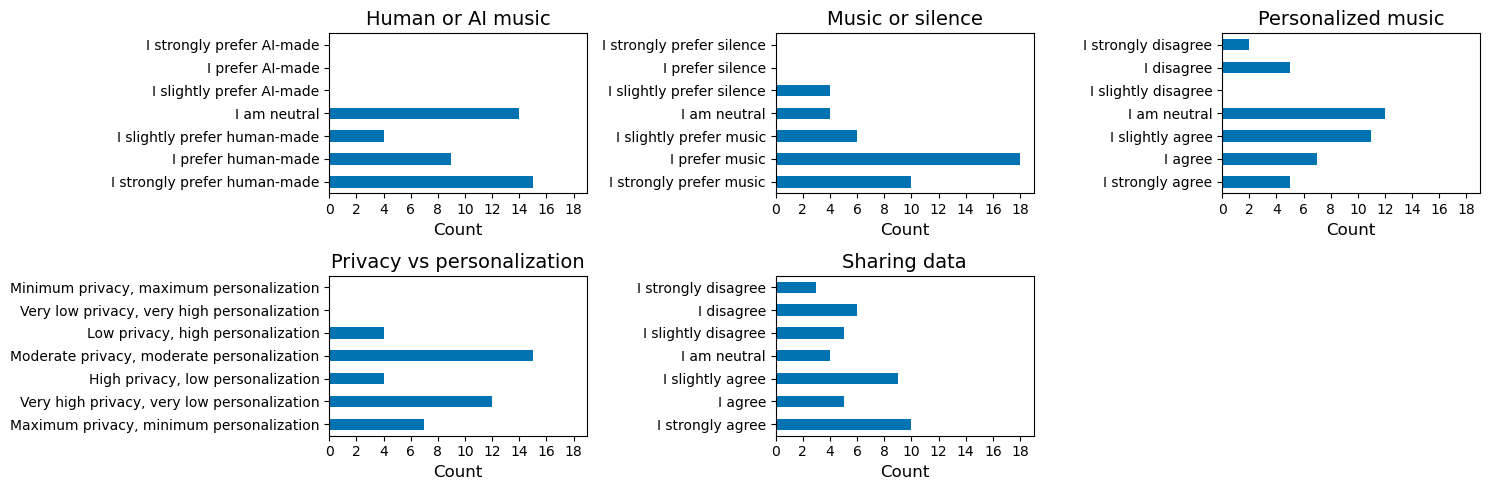

In [272]:
hf.plot_survey(df_survey, columns_to_plot=df_survey.columns[4:9], color=colorblind_palette[0],  output_dir='plots/survey')

### Quiz 

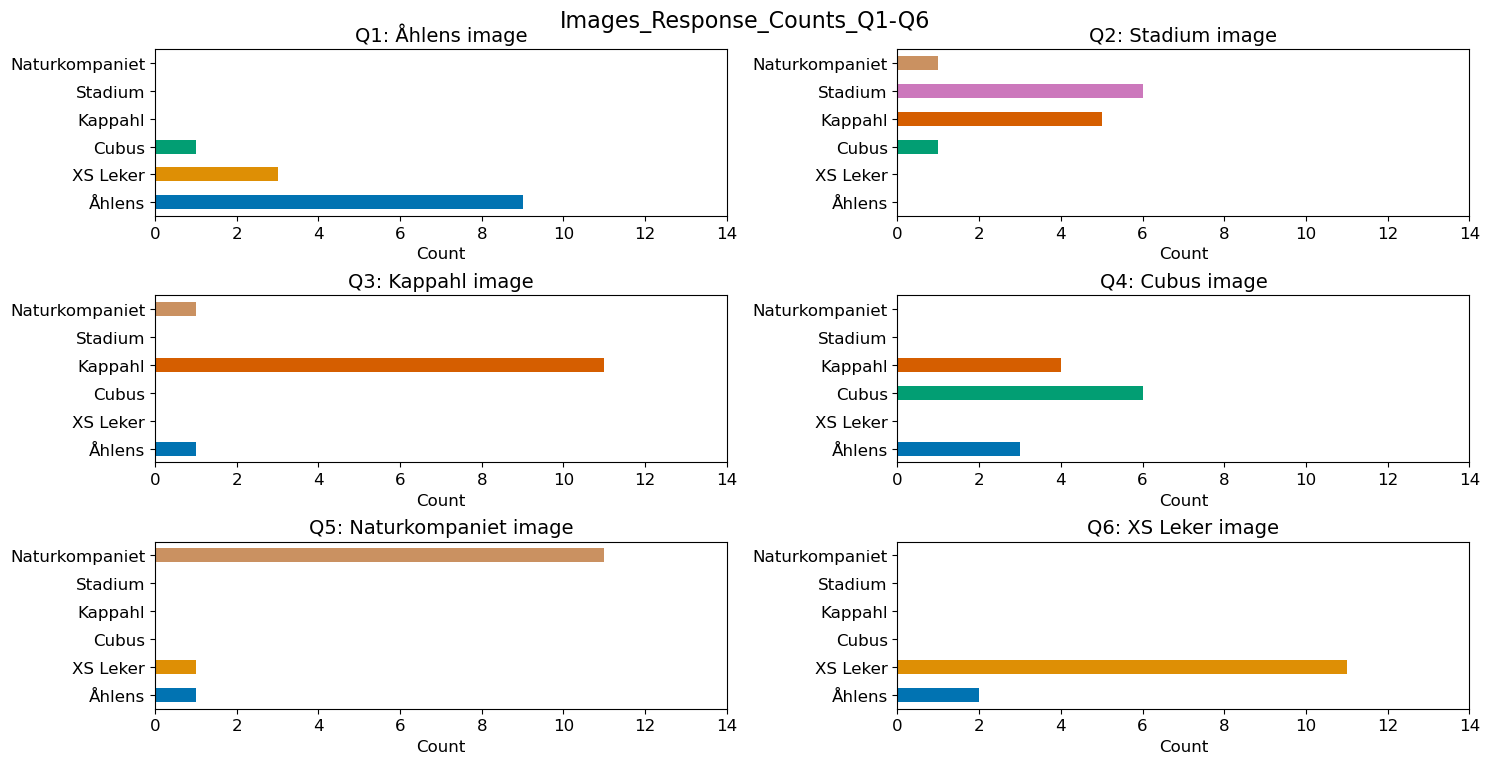

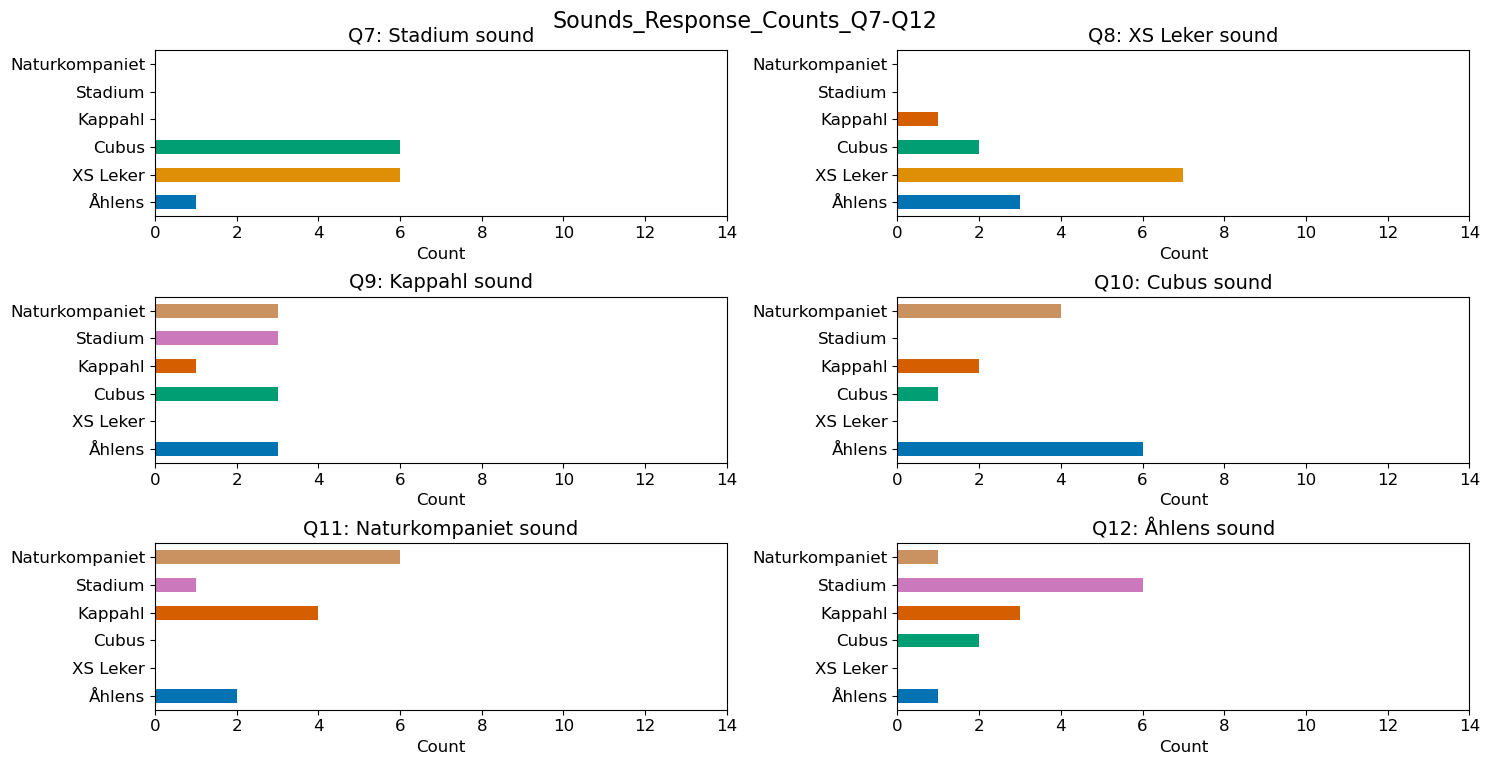

All plots have been saved in the 'plots' directory!


In [273]:
# Create a mapping of each store category to a color
unique_categories = df_quiz[df_quiz.columns[3:]].melt()['value'].dropna().unique() 
color_map = {category: colorblind_palette[i] for i, category in enumerate(unique_categories)}

def plot_and_save_questions(df, title, output_dir='plots/quiz'):
    # Create directory if it doesn't exist
    ensure_directory(output_dir)
    
    # Create main figure
    fig = plt.figure(figsize=(15, 8))
    # Count non-null values in each column and pick maximum 
    max_count = df.count().max() + 1  # Set max count for x-axis
    
    # Store individual plot data
    individual_plots = []
    
    for i, col in enumerate(df.columns, 1):
        # Create subplot in main figure
        ax = plt.subplot(3, 2, i)
        # Count occurrences of each response
        counts = df[col].value_counts()
        # Create a bar plot using counts
        counts = counts.reindex(unique_categories, fill_value=0)
        counts.plot(kind='barh', ax=ax, color=[color_map[category] for category in counts.index])
        
        subplot_title = f"{col}: {correct_answers_dict[col]}"
        plt.title(subplot_title, wrap=True, fontsize=14)  # Increased subplot title size
        plt.xlabel("Count", fontsize=12)  # Increased x-label size
        plt.ylabel("")
        ax.set_xlim(0, max_count)
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        
        # Increase tick label sizes
        ax.tick_params(axis='both', labelsize=12)
        
        # Increase legend font size
        #legend = ax.legend(fontsize=12)
        #legend.set_title("Response", prop={'size': 12})
        
        # Save individual subplot
        individual_fig = plt.figure(figsize=(8, 5))
        individual_ax = individual_fig.add_subplot(111)
        counts.plot(kind='barh', ax=individual_ax, color=[color_map[category] for category in counts.index])
        individual_ax.set_title(subplot_title, wrap=True, fontsize=14)  # Increased individual plot title size
        individual_ax.set_xlabel("Count", fontsize=12)  # Increased individual plot x-label size
        individual_ax.set_ylabel("")
        individual_ax.set_xlim(0, max_count)
        individual_ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        
        # Increase tick label sizes for individual plots
        individual_ax.tick_params(axis='both', labelsize=12)
               
        # Save individual plot
        filename = f"{output_dir}/{col.lower()}_plot.png"
        individual_fig.tight_layout()
        individual_fig.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close(individual_fig)
        
    # Finish and save main figure
    plt.figure(fig.number)
    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=0.95)  # Increased main title size and adjusted position
    plt.subplots_adjust(top=0.9)
    
    # Save complete figure
    main_filename = f"{output_dir}/subplots_{title.lower().replace(' ', '_').replace(':', '')}.png"
    plt.savefig(main_filename, dpi=300, bbox_inches='tight')
    plt.show()
  
# Plot and save Q1-Q6
df_images = df_quiz[image_list]
plot_and_save_questions(df_images, "Images_Response_Counts_Q1-Q6")

# Plot and save Q7-Q12
df_sounds = df_quiz[sound_list]
plot_and_save_questions(df_sounds, "Sounds_Response_Counts_Q7-Q12")

print("All plots have been saved in the 'plots' directory!")

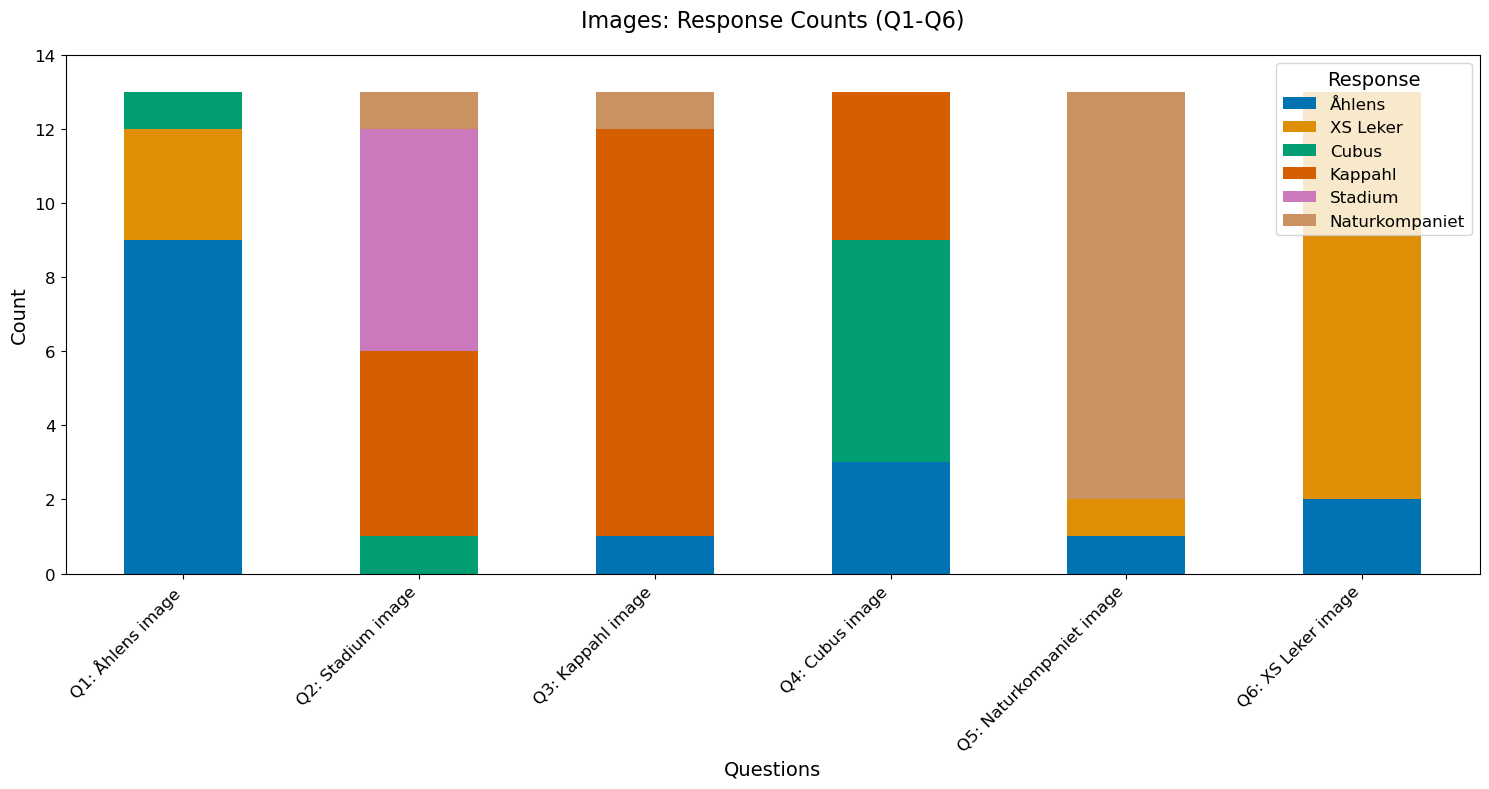

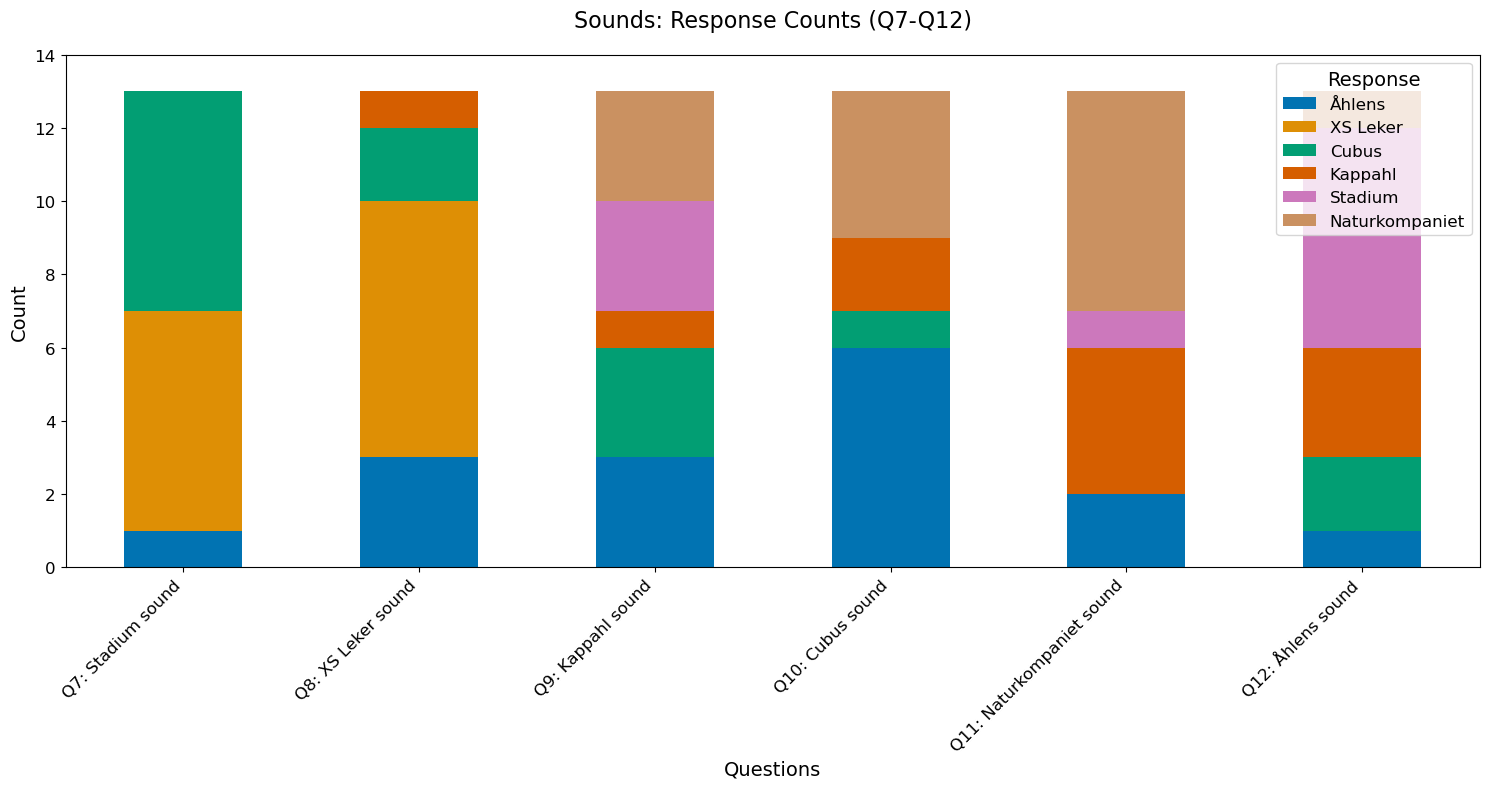

In [85]:
def plot_stacked_bar(df_subset, title, label_dict=correct_answers_dict, output_dir='plots/quiz'):
    # Create directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # Create figure
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Calculate value counts for each question and fill NaNs with 0
    response_counts = df_subset.apply(pd.Series.value_counts).fillna(0).T
    response_counts = response_counts.reindex(columns=unique_categories, fill_value=0)
    
    # Create plot
    response_counts.plot(kind='bar', stacked=True, ax=ax, color=color_map.values())
    
    # Set title with larger font
    plt.title(title, fontsize=16, pad=20)
    
    # Set axis labels with larger font
    plt.xlabel("Questions", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    
    # Set x-axis labels combining question number and description
    x_labels = [f"{col}: {label_dict[col]}" for col in df_subset.columns]
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=12)  # Increased tick label size
    
    # Increase y-axis tick label size
    ax.tick_params(axis='y', labelsize=12)
    
    plt.ylim(0, response_counts.sum(axis=1).max() + 1)  # Set y-axis limit
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Only show integer ticks
    
    # Set legend with larger font
    plt.legend(title="Response", loc='upper right', fontsize=12)  # Increase legend text size
    ax.get_legend().set_title("Response", prop={'size': 14})  # Increase legend title size
    
    # Adjust layout and save
    plt.tight_layout()
    filename = f"{output_dir}/stacked_{title.lower().replace(' ', '_').replace(':', '')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()

# Plot Q1-Q6
df_images = df_quiz[image_list]
plot_stacked_bar(df_images, "Images: Response Counts (Q1-Q6)")

# Plot Q7-Q12
df_sounds = df_quiz[sound_list]
plot_stacked_bar(df_sounds, "Sounds: Response Counts (Q7-Q12)")

In [86]:
df_sounds

,Q7,Q8,Q9,Q10,Q11,Q12
4,Cubus,Cubus,Naturkompaniet,Åhlens,Naturkompaniet,Stadium
5,XS Leker,Åhlens,Cubus,Naturkompaniet,Kappahl,Stadium
6,Cubus,XS Leker,Naturkompaniet,Åhlens,Åhlens,Kappahl
7,Cubus,XS Leker,Kappahl,Åhlens,Naturkompaniet,Stadium
8,Cubus,XS Leker,Åhlens,Naturkompaniet,Kappahl,Stadium
9,XS Leker,Åhlens,Stadium,Cubus,Naturkompaniet,Kappahl
11,XS Leker,Cubus,Stadium,Kappahl,Åhlens,Åhlens
12,Cubus,Kappahl,Åhlens,Naturkompaniet,Stadium,Naturkompaniet
13,XS Leker,Åhlens,Naturkompaniet,Naturkompaniet,Kappahl,Cubus
14,XS Leker,XS Leker,Cubus,Åhlens,Naturkompaniet,Stadium


## Add code to make a confusion matrix here!

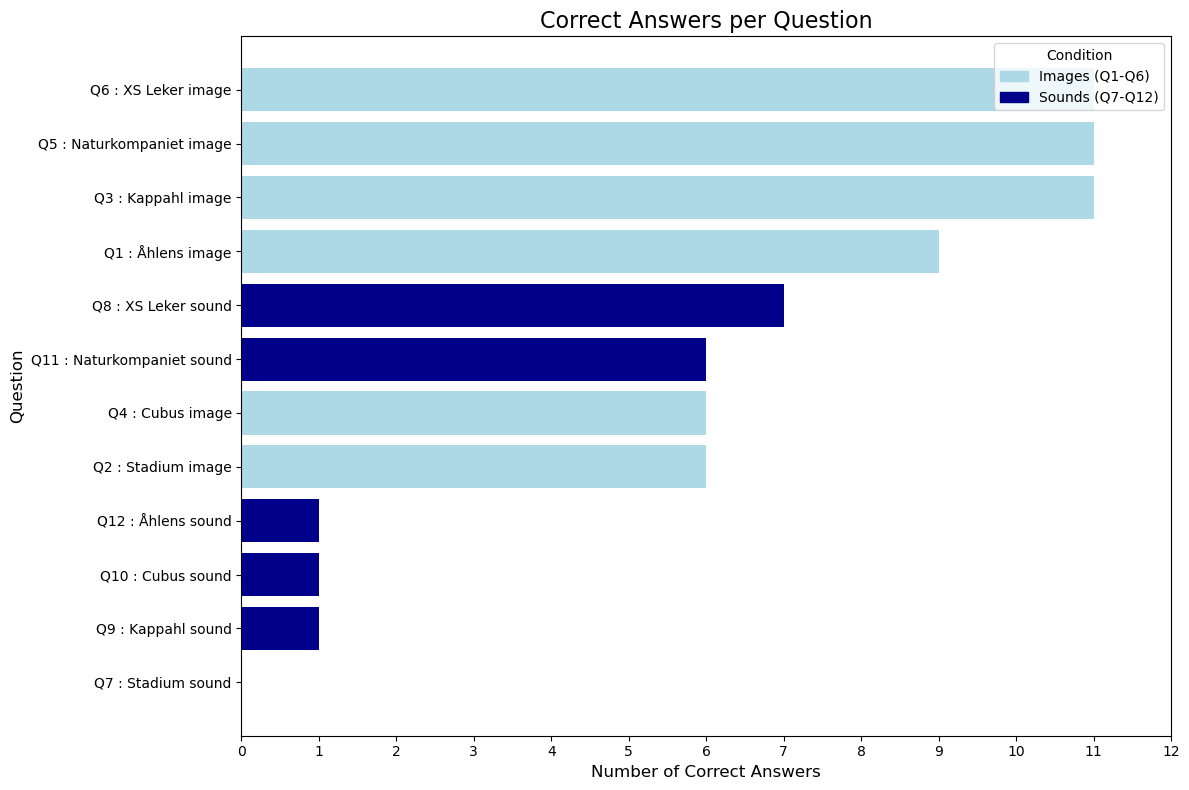

In [274]:
def plot_correct_answers(total_correct_per_question, correct_answers_dict, output_dir='plots/quiz'):
    # Create directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
      
    # Convert Series to DataFrame and rename columns
    correct_answers_df = total_correct_per_question.reset_index()
    correct_answers_df.columns = ['Questions', 'CorrectAnswers']
    correct_answers_df = correct_answers_df.sort_values(by='CorrectAnswers', ascending=True)
    
    # Create detailed labels combining question number and description
    detailed_labels = [f"{q} : {correct_answers_dict[q]}" for q in correct_answers_df['Questions']]
    
    # Define colors based on question groups (images vs sounds)
    colors = ['lightblue' if q in image_list else 'darkblue' 
              for q in correct_answers_df['Questions']]
    
    # Create figure with adjusted size to accommodate longer labels
    plt.figure(figsize=(12, 8))
    
    # Create horizontal bar plot
    plt.barh(range(len(detailed_labels)), correct_answers_df['CorrectAnswers'], color=colors)
    
    # Set the y-tick positions and labels
    plt.yticks(range(len(detailed_labels)), detailed_labels)
    
    plt.title('Correct Answers per Question', fontsize=16)
    plt.xlabel('Number of Correct Answers', fontsize=12)
    plt.ylabel('Question', fontsize=12)
    
    # Set x-axis ticks to integers
    #plt.xticks(range(0, correct_answers_df['CorrectAnswers'].max() + 2))
    plt.xticks(range(0, math.ceil(correct_answers_df['CorrectAnswers'].max()) + 2))

    # Add legend
    legend_handles = [
        patches.Patch(color='lightblue', label='Images (Q1-Q6)'),
        patches.Patch(color='darkblue', label='Sounds (Q7-Q12)')
    ]
    plt.legend(handles=legend_handles, title='Condition', loc='upper right')
    
    # Adjust layout and save
    plt.tight_layout()
    filename = f"{output_dir}/corrects.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()
    plt.close()

plot_correct_answers(total_correct_per_question, correct_answers_dict)

## Save and export results 